# 06. PyTorch Transfer Learning

In [4]:
import torch
import torchvision

from datetime import datetime

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# cuda version
print(f"Cuda version: {torch.version.cuda}")

# created date
print(f"Created date: 2023-08-10 11:10:47")

# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modified date: {now}")

Torch version: 1.12.1
Torchvision version: 0.13.1
Device: cuda
Cuda version: 11.3
Created date: 2023-08-10 11:10:47
Modified date: 2023-08-27 20:32:22


#### What is transfer learning?

- Allows to take the learned patterns (weights) from another model, and use them in our own problems
  
- Our own problems should be similar to the pretrained models's problems

#### Why use transfer learning?

1. Could achieve great results with less custom data
2. Could train faster with a smaller number of trainable parameters

#### Where to find pretrained models

| **Location** | **What's there?** | **Link(s)** | 
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets | 
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ | 

**TORCH.HUB** from [here](https://pytorch.org/docs/stable/hub.html#module-torch.hub)

`Pytorch` `Hub` is a pre-trained model repository designed to facilitate research reproducibility.

#### 0. Getting setup

 **Note:** As of June 2022, The nightly versions of `torch` and `torchvision` as `torchvision` v0.13+ is required for using the updated multi-weights API. 

In [6]:
# run with updated APIs, need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision

    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"

    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"

    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

except:
    print("torch/torchvision versions not as required, installing nightly versions...")
    !pip install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1
torchvision version: 0.13.1


In [7]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

#### 1. Get data

In [8]:
import os
import zipfile

from pathlib import Path

import requests

# setup path to data folder
data_path = Path("../data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find ../data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [9]:
# setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [10]:
train_dir

PosixPath('../data/pizza_steak_sushi/train')

In [11]:
test_dir

PosixPath('../data/pizza_steak_sushi/test')

#### 2. Create Datasets and DataLoaders

##### 2.1 Creating a transform for `torchvision.models` (manual creation)

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. 
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

| **Transform number** | **Transform required** | **Code to perform transform** | 
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]` and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  | 

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

In [12]:
# create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # reshape all images to 224x224
    transforms.ToTensor(), # turn image values to between 0 and 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # across each colour channel
                         std=[0.229, 0.224, 0.225])  # across each colour channel
])

In [13]:
# create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8fe0134a90>,
 ['pizza', 'steak', 'sushi'])

##### 2.2 Creating a transform for `torchvision.models` (auto creation)

 `torchvision` v0.13+, an automatic transform creation feature has been added

To select a pretrained model weights:

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT    
```



- `EfficientNet_B0_Weights` is the model architecture weights (for others in `torchvision.models`)

- `torchvision.models.EfficientNet_B0_Weights.DEFAULT`, where `DEFAULT` means the *the best available weights* (the best performance in ImageNet)

See the [torchvision.models](https://pytorch.org/vision/main/models.html) documentation for more

In [14]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT: the best available weights from pretraining on ImageNet

weights

EfficientNet_B0_Weights.IMAGENET1K_V1

`auto_transforms` came with the model architecture that is selected
`manual_transforms` is created by us

The `benefit` of `automatically` creating a `transform` through `weights.transforms()` ?

- To `ensure` using the `same` data `transformation` as the `pretrained` model `used` when it was trained.


In [15]:
# to access the transforms associated with `weights`
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8fe39fa490>,
 ['pizza', 'steak', 'sushi'])

#### 3. Getting a pretrained model

The idea of `transfer` `learning` is that to take an already well-performing model on a problem-space similar to ours and then customising it to our use case

To find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification)

**A plenty of common computer vision architecture backbones**

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` | 

#### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

Might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

#### 3.2 Setting up a pretrained model

The pretrained model is using [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.


In [42]:
# old (torchvision < v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) 

# UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead
# The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`

In [43]:
# new (torchvision >= v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = the best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

```python
EfficientNet(
  (`features`): Sequential(
    ...
  )
  (`avgpool`): AdaptiveAvgPool2d(output_size=1)
  (`classifier`): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )
)
```

In here,

- `features`:
  - Extracts **features** frome **images**.

- `avgpool`:
  - Turns **features** into **a feature vector** (by taking the average).

- `classifier`: 
  - Turns **a feature vector** into **prediction logits**.
  - The **out_features** from `Linear(in_features=1280, out_features=1000, bias=True)` can be adjusted depending on the number of classes our dataset have.

The `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

#### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [44]:
# a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [45]:
# # a summary using torchinfo
# summary(model=model,
#         input_size=(32, 3, 224, 224),
# col_names = ["input_size, output_size", "num_params", "trainable"],
# col_width=20,
# row_settings=["var_names"]
# )

#### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of **transfer learning** usually goes: 

1. Freeze some base layers of a pretrained model (typically the `features` section) 
2. Then adjust the output layers (also called head/classifier layers) to suit your needs.

**Note:** To *freeze* layers means to keep them how they are during training. 

For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

**Feature extractor layers frozen**

In [46]:
# freeze all base layers in the features section of the model 
for param in model.features.parameters():
    param.requires_grad = False # untrainable

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

In [47]:
# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# get the length of class_names
output_shape = len(class_names)

# recreate the classifier layer 
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True).to(device)
)

In [48]:
# a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

#### 4. Train model

In [49]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
# set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer 
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# end the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Total training time: 5.770 seconds


#### 5. Evaluate model by plotting loss curves

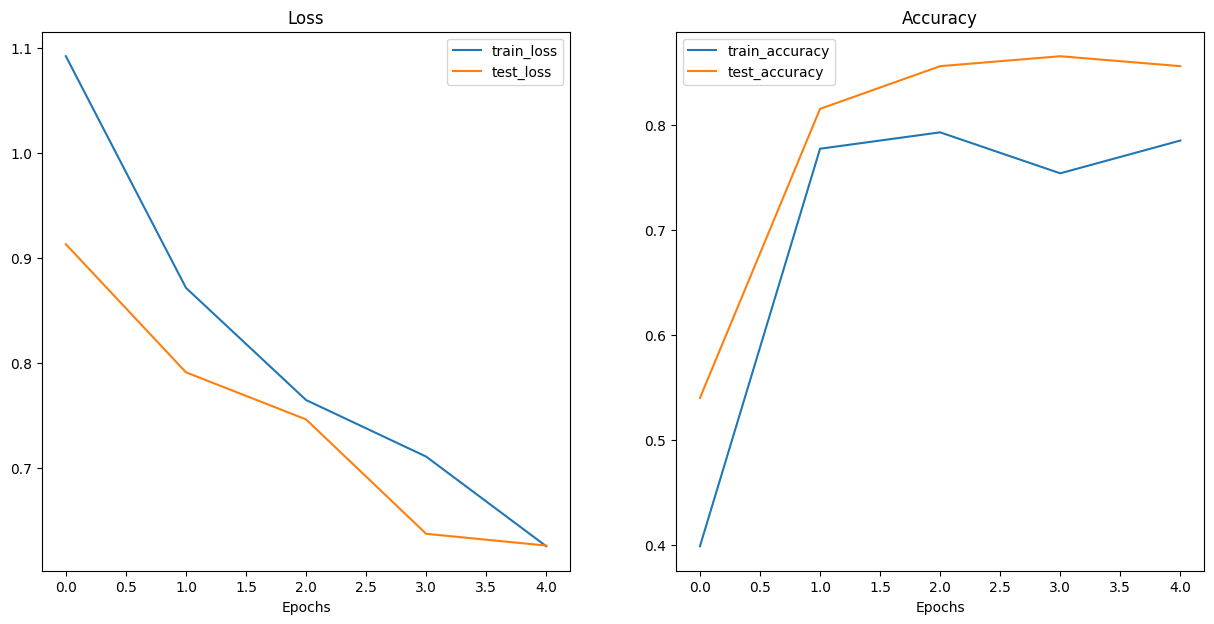

In [51]:
# get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# plot the loss curves of our model
plot_loss_curves(results)

#### 6. Make predictions on images from the test set

In [52]:
from typing import List, Tuple

from PIL import Image

# take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # open image
    img = Image.open(image_path)

    # create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # make sure the model is on the target device
    model.to(device)

    # turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

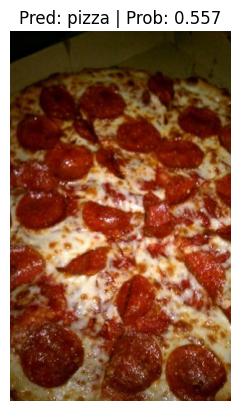

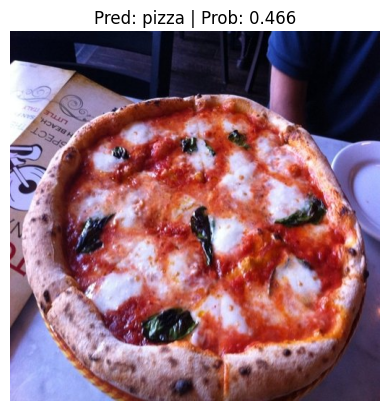

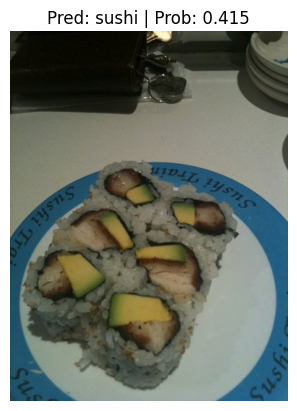

In [53]:
# get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

##### 6.1 Making predictions on a custom image

../data/04-pizza-dad.jpeg already exists, skipping download.


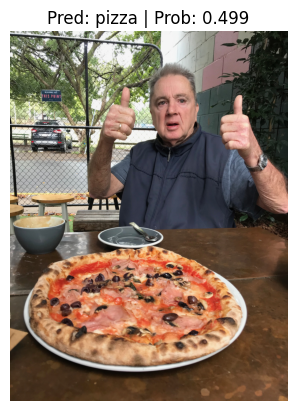

In [54]:
# download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # when downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

#### References

1. https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/
2. [How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers](https://arxiv.org/abs/2106.10270)
3. https://www.fast.ai/
4. https://pytorch.org/vision/stable/models.html
5. https://huggingface.co/models
6. https://pytorch.org/docs/stable/hub.html#module-torch.hub
7. https://github.com/commaai
8. http://www.incompleteideas.net/IncIdeas/BitterLesson.html
9. https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html
10. https://github.com/TylerYep/torchinfo